In [1]:
import sys
sys.path.insert(1, '../Src')
import numpy as np
import pandas as pd
import os
from utils.feature_engineering import *
from utils.preprocessing import *
from utils.analysis import *
import matplotlib.pyplot as plt
import os, sys, gc, time, warnings, pickle, psutil, random

from math import ceil

from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


warnings.filterwarnings('ignore')

#PATH_DATASET = '../Dataset/'
PATH_DATASET = '../Dataset/data-h-m1-challenge-final'
PATH_RESULTS = '../Results/'

FILL = False

In [2]:
submission_top_reference = 'sub_tr01_val_c_model_v1_2.1022_test_2.0908_local_3.18103_kaggle.csv'

In [3]:
SEED = 42

In [4]:
seed_everything(SEED)

In [5]:
print('Reading dataset')

df_sales  = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','df_sales_fe_FILL_'+str(FILL)+'_.pkl'))
df_submission_sample = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','df_submission_sample_fe_FILL_'+str(FILL)+'_.pkl'))

df_sales             = reduce_mem_usage(df_sales)
df_submission_sample = reduce_mem_usage(df_submission_sample)
gc.collect()
print('df_sales size             :',df_sales.shape)
print('df_submission_sample size :',df_submission_sample.shape) 

Reading dataset
Memory usage of dataframe is 868.73 MB
Memory usage after optimization is: 868.73 MB
Decreased by 0.0%
Memory usage of dataframe is 20.01 MB
Memory usage after optimization is: 20.01 MB
Decreased by 0.0%
df_sales size             : (2216312, 151)
df_submission_sample size : (52959, 152)


In [6]:
df_sales.head()

,DATE,S100,I100,C100,C101,QTT,item_id,date_block_num,I101,I102,...,enc_S100_C100_mean_clipped,enc_S100_C100_std_clipped,enc_I100_C101_mean_clipped,enc_I100_C101_std_clipped,enc_I100_S100_mean_clipped,enc_I100_S100_std_clipped,enc_I100_C100_C101_mean_clipped,enc_I100_C100_C101_std_clipped,enc_S100_I100_C100_C101_mean_clipped,enc_S100_I100_C100_C101_std_clipped
0,2017-01-08,0,0,12,76,2,0_12_76,0,2,1,...,0.169922,0.592773,0.090332,0.434326,0.054657,0.317627,0.092957,0.441895,0.042633,0.237793
1,2017-01-08,0,0,12,149,3,0_12_149,0,2,1,...,0.169922,0.592773,0.140137,0.562988,0.054657,0.317627,0.149048,0.579590,0.069763,0.426514
2,2017-01-08,0,0,12,256,3,0_12_256,0,2,1,...,0.169922,0.592773,0.061371,0.319092,0.054657,0.317627,0.068970,0.354980,0.038757,0.303223
3,2017-01-08,0,0,12,354,3,0_12_354,0,2,1,...,0.169922,0.592773,0.165039,0.680664,0.054657,0.317627,0.153320,0.603027,0.089172,0.408691
4,2017-01-08,0,0,13,149,2,0_13_149,0,2,1,...,0.460449,1.367188,0.140137,0.562988,0.054657,0.317627,0.116089,0.479736,0.038757,0.212524


In [9]:
df_submission_sample.head(2)

,ID,QTT,DATE,S100,I100,C100,C101,item_id,date_block_num,I101,...,enc_S100_C100_mean_clipped,enc_S100_C100_std_clipped,enc_I100_C101_mean_clipped,enc_I100_C101_std_clipped,enc_I100_S100_mean_clipped,enc_I100_S100_std_clipped,enc_I100_C100_C101_mean_clipped,enc_I100_C100_C101_std_clipped,enc_S100_I100_C100_C101_mean_clipped,enc_S100_I100_C100_C101_std_clipped
0,2021-12-19_0_1_12_76,-1,2021-12-19,0,1,12,76,1_12_76,258,2,...,0.169922,0.592773,0.677734,1.580078,0.340576,0.774414,0.584961,1.304688,0.513672,1.075195
1,2021-12-19_0_1_12_140,-1,2021-12-19,0,1,12,140,1_12_140,258,2,...,0.169922,0.592773,0.438721,1.067383,0.340576,0.774414,0.355469,0.911133,0.273193,0.705078


In [10]:
features_names = set(df_sales.columns)-set(['QTT','DATE','item_id','ID', 'date_block_num','QTT_clipped']) 
print(len(features_names))

146


In [11]:
X_train      = df_sales[(df_sales['DATE'] >= '2016-01-01') & (df_sales['DATE'] < '2021-05-01')].copy()
X_validation = df_sales[(df_sales['DATE'] >= '2021-05-01') & (df_sales['DATE'] < '2021-08-01')].copy()
X_test       = df_sales[(df_sales['DATE'] >= '2021-08-01') & (df_sales['DATE'] < '2022-10-03')].copy() 

y_train = X_train['QTT']
X_train = X_train[features_names]

y_validation = X_validation['QTT']
X_validation = X_validation[features_names]

y_test = X_test['QTT']
X_test = X_test[features_names]

y_submission = df_submission_sample['QTT']
X_submission = df_submission_sample[features_names]


print('X_train      ',X_train.shape)
print('y_validation ',y_validation.shape)
print('X_test       ',X_test.shape)
print('X_submission ',X_submission.shape)

X_train       (1860415, 146)
y_validation  (142124,)
X_test        (213773, 146)
X_submission  (52959, 146)


In [12]:
#features_names = ['S100', 'I100', 'C100', 'C101', 'month', 'year', 'day','I101', 'I102', 'I103', 'S101', 'S102', 'S103']
features_names = set(df_sales.columns)-set(['QTT','DATE','item_id','ID', 'date_block_num','QTT_clipped']) 
print(len(features_names))

X_train = df_sales[features_names].copy()
y_train = df_sales['QTT']

X_submission = df_submission_sample[features_names].copy()
 
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
print('X_train      :',X_train.shape)
print('X_validation :',X_validation.shape)
print('X_test       :',X_test.shape)

146
X_train      : (1551418, 146)
X_validation : (332447, 146)
X_test       : (332447, 146)


In [13]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    #'objective': 'regression',
   'objective': 'tweedie',
   'tweedie_variance_power': 1.1,
    'metric': ['rmse','l1','l2'],
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': -1,
    "max_depth": 10,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 8000
}

In [14]:
gbm2 = lgb.LGBMRegressor(**hyper_params)
gbm2.fit(X_train, y_train,
        eval_set=[(X_validation, y_validation)],
        eval_metric='rmse',
        early_stopping_rounds=100)

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[1]	valid_0's rmse: 3.11053	valid_0's l1: 1.61287	valid_0's l2: 9.6754
[2]	valid_0's rmse: 3.00053	valid_0's l1: 1.55029	valid_0's l2: 9.00321
[3]	valid_0's rmse: 2.89343	valid_0's l1: 1.49537	valid_0's l2: 8.37193
[4]	valid_0's rmse: 2.7933	valid_0's l1: 1.44712	valid_0's l2: 7.80253
[5]	valid_0's rmse: 2.7025	valid_0's l1: 1.40684	valid_0's l2: 7.30349
[6]	valid_0's rmse: 2.62268	valid_0's l1: 1.37463	valid_0's l2: 6.87843
[7]	valid_0's rmse: 2.55364	valid_0's l1: 1.34836	valid_0's l2: 6.52109
[8]	valid_0's rmse: 2.49556	valid_0's l1: 1.32675	valid_0's l2: 6.2278
[9]	valid_0's rmse: 2.44423	valid_0's l1: 1.30875	valid_0's l2: 5.97425
[10]	

LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, feature_fraction=0.9,
              max_bin=512, max_depth=10, metric=['rmse', 'l1', 'l2'],
              num_iterations=8000, num_leaves=128, objective='tweedie',
              task='train', tweedie_variance_power=1.1, verbose=-1)


hyper_params ={      
  'boosting_type': 'gbdt',
   'objective': 'tweedie',
   'tweedie_variance_power': 1.1,
    'metric': 'rmse',
    'subsample': 0.6,
    'subsample_freq': 1,
    'learning_rate': 0.1,
    'num_leaves': 2**11-1,
    'min_data_in_leaf': 2**12-1,
    'feature_fraction': 0.6,
    'max_bin': 100,
    'boost_from_average': False,
    'verbose': -1,
    'num_threads': 8
   }    

lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_validation, y_validation)

gbm2 = lgb.train(hyper_params, lgb_train, 3000, valid_sets=[lgb_train, lgb_valid],early_stopping_rounds=100, verbose_eval=50)


In [15]:
X_submission = df_submission_sample[features_names]

In [16]:
import numpy as np

model_version = 'c_model_v1'

In [17]:
print('make predictions...')
#gbm2 = gbm
X_train_pred      = gbm2.predict(X_train)#, num_iteration=gbm.best_iteration_)
X_validation_pred = gbm2.predict(X_validation)#, num_iteration=gbm.best_iteration_)
X_test_pred       = gbm2.predict(X_test)#, num_iteration=gbm.best_iteration_)



X_train_pred = np.maximum(X_train_pred, 0)
X_validation_pred = np.maximum(X_validation_pred, 0)
X_test_pred = np.maximum(X_test_pred, 0)


df_train_rmse = mean_squared_error(y_train,X_train_pred, squared=False)
df_val_rmse   = mean_squared_error(y_validation,X_validation_pred, squared=False)
df_test_rmse  = mean_squared_error(y_test,X_test_pred, squared=False)

print('Final score mean_squared_error')
print('Score train:',df_train_rmse)
print('Score val  :',df_val_rmse)
print('Score test :',df_test_rmse)


model_name = os.path.join(PATH_RESULTS,'lightgbm',model_version,'model_val_'+str(np.round(df_val_rmse,2))+'_test_'+str(np.round(df_test_rmse,2))+'.txt')
print('saving model..',model_name)
#gbm2.save_model(model_name, num_iteration=gbm2.best_iteration)

make predictions...
Final score mean_squared_error
Score train: 1.8454006018652125
Score val  : 2.1044649511526057
Score test : 2.0889629630409434
saving model.. ../Results/lightgbm/c_model_v1/model_val_2.1_test_2.09.txt


In [18]:
X_submission_pred = gbm2.predict(X_submission.values)#, num_iteration=gbm.best_iteration_)
X_submission_pred = np.maximum(X_submission_pred, 0)


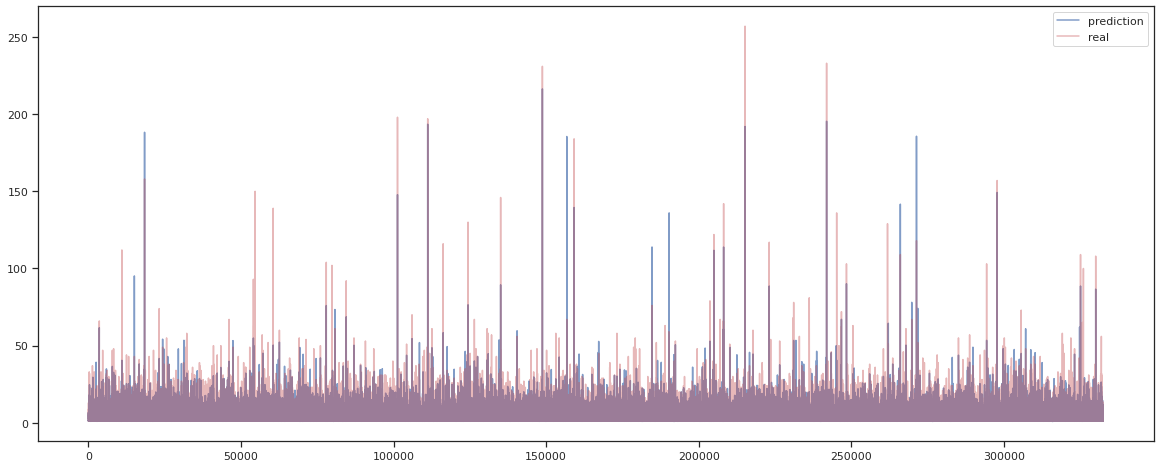

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,8))
plt.plot(X_test_pred,'b', alpha=0.7)
plt.plot(y_test.values,'r', alpha=0.4)
plt.legend(["prediction", "real"], loc ="upper right")

plt.show()

In [20]:
df_submission_sample.reset_index(drop=True,inplace=True)
df_submission_sample['QTT'] = X_submission_pred
df_submission_sample.head()

,ID,QTT,DATE,S100,I100,C100,C101,item_id,date_block_num,I101,...,enc_S100_C100_mean_clipped,enc_S100_C100_std_clipped,enc_I100_C101_mean_clipped,enc_I100_C101_std_clipped,enc_I100_S100_mean_clipped,enc_I100_S100_std_clipped,enc_I100_C100_C101_mean_clipped,enc_I100_C100_C101_std_clipped,enc_S100_I100_C100_C101_mean_clipped,enc_S100_I100_C100_C101_std_clipped
0,2021-12-19_0_1_12_76,2.470006,2021-12-19,0,1,12,76,1_12_76,258,2,...,0.169922,0.592773,0.677734,1.580078,0.340576,0.774414,0.584961,1.304688,0.513672,1.075195
1,2021-12-19_0_1_12_140,1.789049,2021-12-19,0,1,12,140,1_12_140,258,2,...,0.169922,0.592773,0.438721,1.067383,0.340576,0.774414,0.355469,0.911133,0.273193,0.705078
2,2021-12-19_0_1_12_164,1.710255,2021-12-19,0,1,12,164,1_12_164,258,2,...,0.169922,0.592773,0.380371,1.001953,0.340576,0.774414,0.366455,0.950684,0.323242,0.710938
3,2021-12-19_0_1_12_201,1.633975,2021-12-19,0,1,12,201,1_12_201,258,2,...,0.169922,0.592773,0.373779,0.889648,0.340576,0.774414,0.294678,0.772949,0.273193,0.633789
4,2021-12-19_0_1_12_339,1.633388,2021-12-19,0,1,12,339,1_12_339,258,2,...,0.169922,0.592773,0.346924,0.872559,0.340576,0.774414,0.254150,0.691895,0.264648,0.644043


In [21]:
filename_submission= 'sub_tr01_val_'+model_version+'_'+str(np.round(df_val_rmse,4))+'_test_'+str(np.round(df_test_rmse,4))+'_local.csv'
save = True
if save:
    print('saving..')
    print(filename_submission)
    df_submission_sample[['ID','QTT']].to_csv(os.path.join(PATH_RESULTS,'submissions',filename_submission),index=None)

saving..
sub_tr01_val_c_model_v1_2.1045_test_2.089_local.csv


In [22]:
result = pd.read_csv(os.path.join(PATH_RESULTS,'submissions',submission_top_reference))

In [23]:
df_submission_sample['QTT_reference']= result['QTT'].copy()
df_submission_sample[['QTT_reference','QTT']][-20:]

,QTT_reference,QTT
52939,1.224925,1.161109
52940,2.392287,2.244272
52941,2.496071,2.554542
52942,3.448813,2.931367
52943,2.090473,2.334674
52944,3.027003,2.810233
52945,3.959452,3.493759
52946,2.725231,2.643705
52947,1.686848,1.607019
52948,0.982742,1.074126


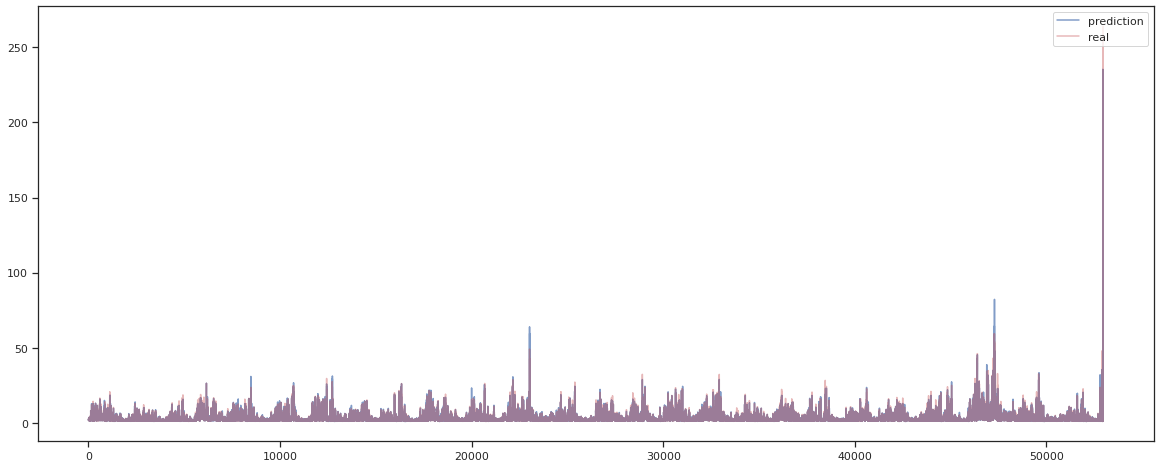

In [24]:
fig = plt.figure(figsize=(20,8))
plt.plot(df_submission_sample['QTT'],'b', alpha=0.7)
plt.plot(result['QTT'],'r', alpha=0.4)
plt.legend(["prediction", "real"], loc ="upper right")
plt.show()

In [25]:
difference = mean_squared_error(df_submission_sample['QTT'],result['QTT'], squared=False)

print('Final score mean_squared_error')
print('Score train:',difference)

Final score mean_squared_error
Score train: 0.5377618414133873


In [26]:
import numpy as np 
import pandas as pd 
import os
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
import datetime
import time
import sys

In [27]:
X_train      = df_sales#[(df_sales['DATE'] >= '2019-01-01')].copy()# & (df_sales['DATE'] < '2021-08-01')].copy()
#X_validation = df_sales[(df_sales['DATE'] >= '2021-05-01') & (df_sales['DATE'] < '2021-08-01')].copy()
#X_test       = df_sales[(df_sales['DATE'] >= '2021-08-01') & (df_sales['DATE'] <= '2021-10-03')].copy() 


y_train = X_train['QTT']
X_train = X_train[features_names]

#y_validation = X_validation['QTT']
#X_validation = X_validation[features_names]

#y_test = X_test['QTT']
#X_test = X_test[features_names]

y_submission = df_submission_sample['QTT']
X_submission = df_submission_sample[features_names]

In [28]:


params ={      
   'device' : 'cpu',
    'boosting_type': 'gbdt',
   'objective': 'tweedie',
   'tweedie_variance_power': 1.1,
    'metric': 'rmse',
    'subsample': 0.6,
    'subsample_freq': 1,
    'learning_rate': 0.1,

    #'num_leaves': 200, #110 #100 #150 large, but over-fitting
    #'max_depth': 10, # deal with over-fitting
    #'min_data_in_leaf': 30, # deal with over-fitting
    
    'num_leaves': 2**11-1,
    'min_data_in_leaf': 2**12-1,
    
    'feature_fraction': 0.6,
    'max_bin': 100,
    #'n_estimators': …,   
    'boost_from_average': False,
    'verbose': -1,
    'num_threads': 8
   }    

In [29]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    #'objective': 'regression',
   'objective': 'tweedie',
   'tweedie_variance_power': 1.1,
    'metric': ['rmse','l1','l2'],
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 10,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 8000
}

In [30]:
model_version = 'c_model_v2'

nfolds = 5

nrepeats = 2 
folds = RepeatedKFold(n_splits=nfolds, n_repeats=nrepeats, random_state=11)

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=nfolds, random_state=11, shuffle=True)
skf.get_n_splits(X_train, y_train)
print(skf)


fold_pred = np.zeros(len(X_train))


feature_importance_df = pd.DataFrame()

predictions_submission = pd.DataFrame()

lgb_preds = np.zeros(len(X_submission))

#for fold_, (trn_idx, val_idx) in enumerate(folds.split(y_train.values,y_train.values)):
for fold_, (trn_idx, val_idx) in enumerate(skf.split(y_train.values,y_train.values)):
    
    print(20*'*'," fold n°{}".format(fold_))
    
    trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx]) #categorical_feature=categorical_feats
    val_data = lgb.Dataset(X_train.iloc[val_idx], label=y_train.iloc[val_idx]) #categorical_feature=categorical_feats

    print('Training ...')
    iteration = 3000
    lgb_model = lgb.train(params, trn_data, iteration, valid_sets = [trn_data, val_data], verbose_eval=50, early_stopping_rounds = 100)
    
    print('make predictions...')
    X_train_pred      = lgb_model.predict(X_train.iloc[trn_idx], num_iteration=lgb_model.best_iteration)
    X_validation_pred = lgb_model.predict(X_train.iloc[val_idx], num_iteration=lgb_model.best_iteration)
    #X_test_pred       = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

    X_train_pred = np.maximum(X_train_pred, 0)
    X_validation_pred = np.maximum(X_validation_pred, 0)
    #X_test_pred = np.maximum(X_test_pred, 0)

    

    df_train_rmse = mean_squared_error(y_train.iloc[trn_idx],X_train_pred, squared=False)
    df_val_rmse   = mean_squared_error(y_train.iloc[val_idx],X_validation_pred, squared=False)
    #df_test_rmse  = mean_squared_error(y_test,X_test_pred, squared=False)

    print('Final score mean_squared_error')
    print('Score train:',df_train_rmse)
    print('Score val  :',df_val_rmse)
    #print('Score test :',df_test_rmse)


    fold_pred[val_idx] = X_validation_pred
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = X_train.columns
    fold_importance_df["importance"] = lgb_model.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    
    
    print('Predict submission ')
    X_submission_pred = lgb_model.predict(X_submission.values, num_iteration=lgb_model.best_iteration)
    X_submission_pred = np.maximum(X_submission_pred, 0)

    #lgb_preds += X_submission_pred / (nfolds*nrepeats)
    lgb_preds += X_submission_pred / (nfolds)
    
    predictions_submission[str(fold_ + 1)] = X_submission_pred
    
    
    model_name = os.path.join(PATH_RESULTS,'lightgbm',model_version,'model_fold_'+str(fold_ + 1)+'.txt')
    print('saving model..',model_name)
    lgb_model.save_model(model_name, num_iteration=lgb_model.best_iteration)
    
    #############################

print("CV score: {:<8.5f}".format(np.sqrt(mean_squared_error(fold_pred, y_train))))

StratifiedKFold(n_splits=5, random_state=11, shuffle=True)
********************  fold n°0
Training ...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.189389 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 2.02911	training's l1: 1.1649	training's l2: 4.11729	valid_1's rmse: 2.1069	valid_1's l1: 1.17509	valid_1's l2: 4.43905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's rmse: 1.93732	training's l1: 1.1421	training's l2: 3.75321	valid_1's rmse: 2.08036	valid_1's l1: 1.16239	valid_1's l2: 4.32788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

In [31]:
cv_score = np.sqrt(mean_squared_error(fold_pred, y_train))

In [32]:
# ranking all feature by avg importance score from Kfold, select top100
all_features = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)
all_features.reset_index(inplace=True)
important_features = list(all_features[0:30]['feature'])
all_features[0:30]

,feature,importance
0,day_of_year,2475.0
1,enc_S100_I100_C100_C101_std_clipped,1394.2
2,enc_S100_I100_C100_C101_mean_clipped,1094.0
3,I100,948.4
4,day,618.8
5,year,576.8
6,C101,544.2
7,enc_I100_S100_std_clipped,524.2
8,rolling_mean_tmp_I100_1_7_I100_C100_C101,499.0
9,enc_I100_S100_mean_clipped,496.6


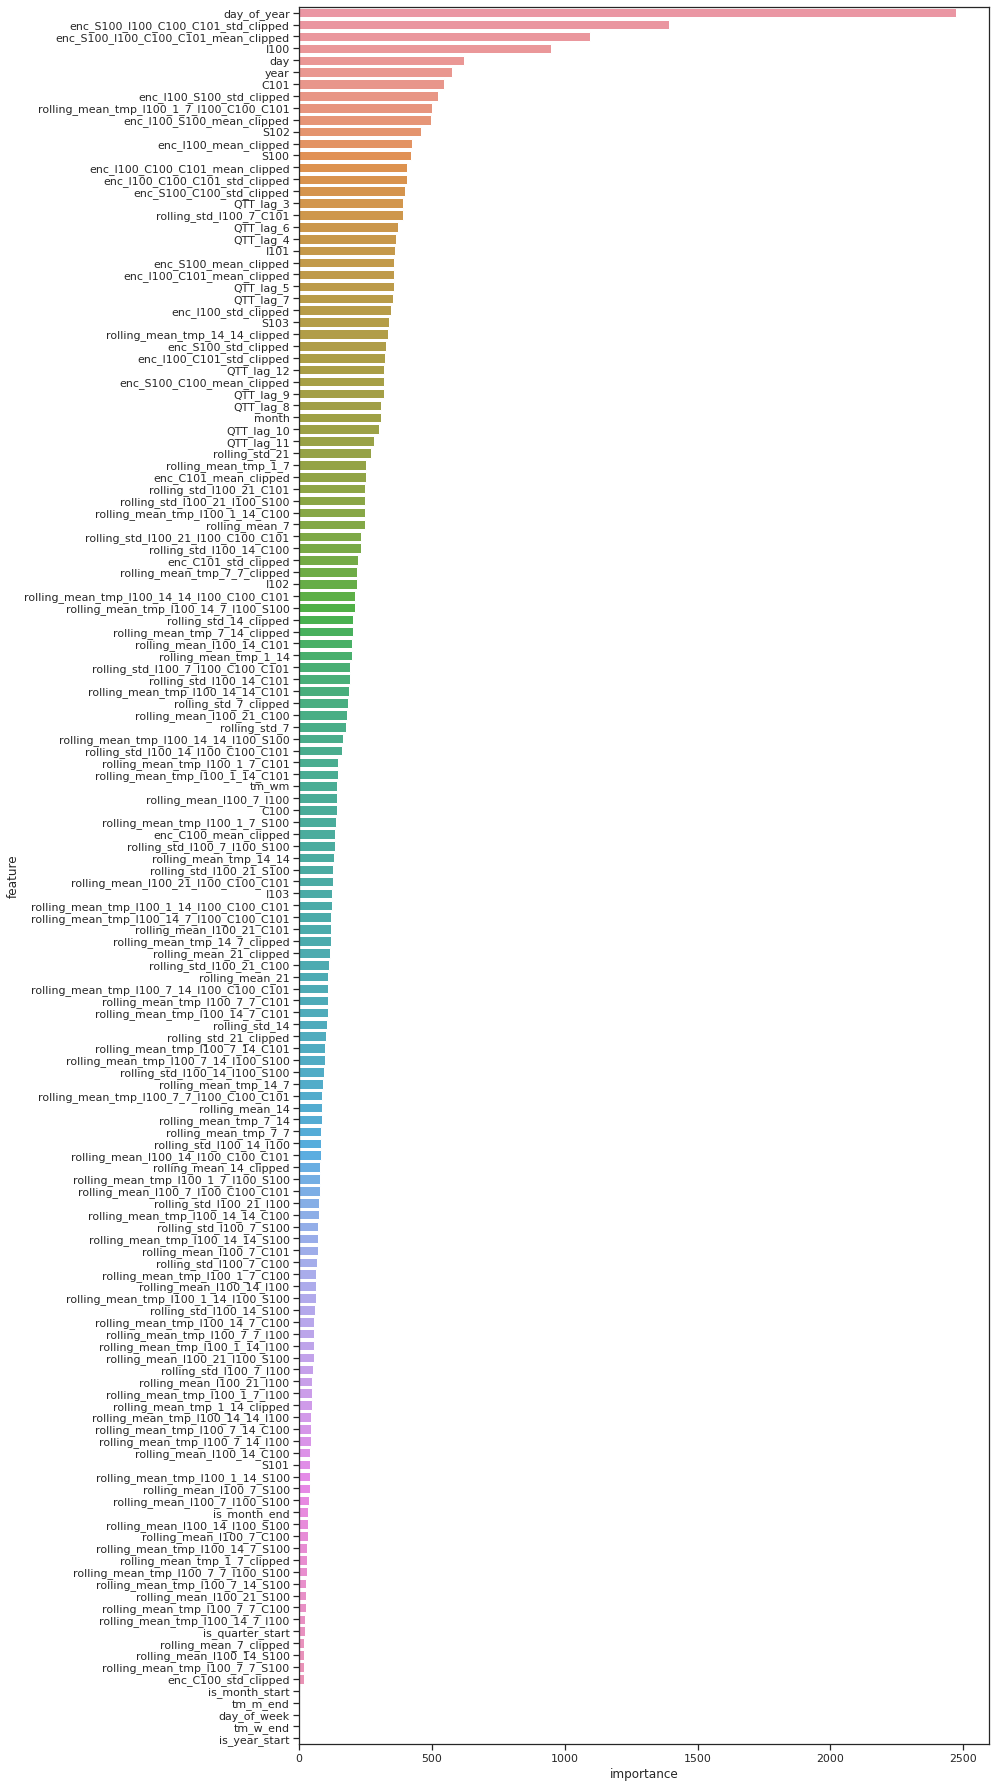

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,25))
sns.barplot(x="importance",y="feature",data=all_features)
plt.tight_layout()
plt.savefig(os.path.join(PATH_RESULTS,'all_data_lgbm_importances.png'))

In [34]:
df_submission_sample.reset_index(drop=True,inplace=True)
df_submission_sample['QTT'] = predictions_submission.mean(axis=1)
df_submission_sample.head()

,ID,QTT,DATE,S100,I100,C100,C101,item_id,date_block_num,I101,...,enc_S100_C100_std_clipped,enc_I100_C101_mean_clipped,enc_I100_C101_std_clipped,enc_I100_S100_mean_clipped,enc_I100_S100_std_clipped,enc_I100_C100_C101_mean_clipped,enc_I100_C100_C101_std_clipped,enc_S100_I100_C100_C101_mean_clipped,enc_S100_I100_C100_C101_std_clipped,QTT_reference
0,2021-12-19_0_1_12_76,2.500241,2021-12-19,0,1,12,76,1_12_76,258,2,...,0.592773,0.677734,1.580078,0.340576,0.774414,0.584961,1.304688,0.513672,1.075195,2.544001
1,2021-12-19_0_1_12_140,1.849556,2021-12-19,0,1,12,140,1_12_140,258,2,...,0.592773,0.438721,1.067383,0.340576,0.774414,0.355469,0.911133,0.273193,0.705078,1.771426
2,2021-12-19_0_1_12_164,1.855134,2021-12-19,0,1,12,164,1_12_164,258,2,...,0.592773,0.380371,1.001953,0.340576,0.774414,0.366455,0.950684,0.323242,0.710938,1.875576
3,2021-12-19_0_1_12_201,1.650175,2021-12-19,0,1,12,201,1_12_201,258,2,...,0.592773,0.373779,0.889648,0.340576,0.774414,0.294678,0.772949,0.273193,0.633789,1.648686
4,2021-12-19_0_1_12_339,1.665803,2021-12-19,0,1,12,339,1_12_339,258,2,...,0.592773,0.346924,0.872559,0.340576,0.774414,0.254150,0.691895,0.264648,0.644043,1.645443


saving..
training_sub_c_model_v2_cv_2.0882_local.csv


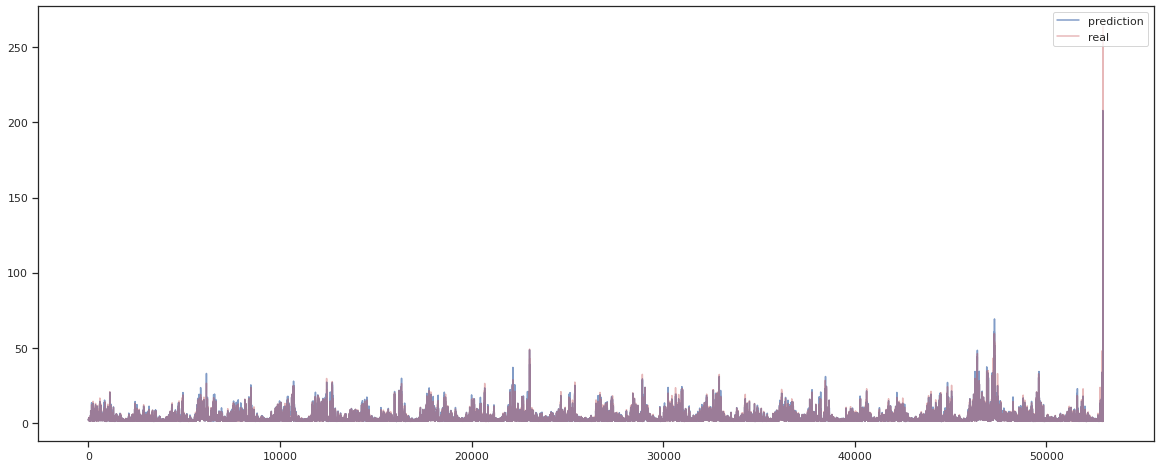

Final score mean_squared_error
Score train: 0.5184263632945434


In [35]:
save = True
if save:
    filename_submission= 'training_sub_'+model_version+'_cv_'+str(np.round(cv_score,4))+'_local.csv'
    print('saving..')
    print(filename_submission)
    df_submission_sample[['ID','QTT']].to_csv(os.path.join(PATH_RESULTS,'submissions',filename_submission),index=None)
    
###################
result = pd.read_csv(os.path.join(PATH_RESULTS,'submissions',submission_top_reference))

df_submission_sample['QTT_reference']= result['QTT'].copy()
df_submission_sample[['QTT_reference','QTT']][-20:]

fig = plt.figure(figsize=(20,8))
plt.plot(df_submission_sample['QTT'],'b', alpha=0.7)
plt.plot(result['QTT'],'r', alpha=0.4)
plt.legend(["prediction", "real"], loc ="upper right")
plt.show()

#######
difference = mean_squared_error(df_submission_sample['QTT'],result['QTT'], squared=False)

print('Final score mean_squared_error')
print('Score train:',difference)


In [36]:
features_names = important_features


X_train      = df_sales#[(df_sales['DATE'] >= '2019-01-01')].copy()# & (df_sales['DATE'] < '2021-08-01')].copy()
#X_validation = df_sales[(df_sales['DATE'] >= '2021-05-01') & (df_sales['DATE'] < '2021-08-01')].copy()
#X_test       = df_sales[(df_sales['DATE'] >= '2021-08-01') & (df_sales['DATE'] <= '2021-10-03')].copy() 


y_train = X_train['QTT']
X_train = X_train[features_names]

#y_validation = X_validation['QTT']
#X_validation = X_validation[features_names]

#y_test = X_test['QTT']
#X_test = X_test[features_names]

y_submission = df_submission_sample['QTT']
X_submission = df_submission_sample[features_names]


In [37]:
model_version = 'c_model_v3'

nfolds = 5

nrepeats = 2 

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=nfolds, random_state=11, shuffle=True)
skf.get_n_splits(X_train, y_train)
print(skf)
    
folds = RepeatedKFold(n_splits=nfolds, n_repeats=nrepeats, random_state=11)


fold_pred_fi = np.zeros(len(X_train))


feature_importance_df_fi = pd.DataFrame()
predictions_submission_fi = pd.DataFrame()

lgb_preds_fi = np.zeros(len(X_submission))

#for fold_, (trn_idx, val_idx) in enumerate(folds.split(y_train.values,y_train.values)):
for fold_, (trn_idx, val_idx) in enumerate(skf.split(y_train.values,y_train.values)):
    
    print(20*'*'," fold n°{}".format(fold_))
    
    trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx]) #categorical_feature=categorical_feats
    val_data = lgb.Dataset(X_train.iloc[val_idx], label=y_train.iloc[val_idx]) #categorical_feature=categorical_feats

    print('Training ...')
    iteration = 3000
    lgb_model = lgb.train(params, trn_data, iteration, valid_sets = [trn_data, val_data], verbose_eval=50, early_stopping_rounds = 100)
    
    print('make predictions...')
    X_train_pred      = lgb_model.predict(X_train.iloc[trn_idx], num_iteration=lgb_model.best_iteration)
    X_validation_pred = lgb_model.predict(X_train.iloc[val_idx], num_iteration=lgb_model.best_iteration)
    #X_test_pred       = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

    X_train_pred = np.maximum(X_train_pred, 0)
    X_validation_pred = np.maximum(X_validation_pred, 0)
    #X_test_pred = np.maximum(X_test_pred, 0)

    

    df_train_rmse = mean_squared_error(y_train.iloc[trn_idx],X_train_pred, squared=False)
    df_val_rmse   = mean_squared_error(y_train.iloc[val_idx],X_validation_pred, squared=False)
    #df_test_rmse  = mean_squared_error(y_test,X_test_pred, squared=False)

    print('Final score mean_squared_error')
    print('Score train:',df_train_rmse)
    print('Score val  :',df_val_rmse)
    #print('Score test :',df_test_rmse)


    fold_pred_fi[val_idx] = X_validation_pred
    
    fold_importance_df_fi = pd.DataFrame()
    fold_importance_df_fi["feature"] = X_train.columns
    fold_importance_df_fi["importance"] = lgb_model.feature_importance()
    fold_importance_df_fi["fold"] = fold_ + 1
    feature_importance_df_fi = pd.concat([feature_importance_df_fi, fold_importance_df_fi], axis=0)
    
    
    
    print('Predict submission ')
    X_submission_pred = lgb_model.predict(X_submission.values, num_iteration=lgb_model.best_iteration)
    X_submission_pred = np.maximum(X_submission_pred, 0)

    #lgb_preds_fi += X_submission_pred / (nfolds*nrepeats)
    lgb_preds_fi += X_submission_pred / (nfolds)
    
    predictions_submission_fi[str(fold_ + 1)] = X_submission_pred
    
    
    model_name = os.path.join(PATH_RESULTS,'lightgbm',model_version,'model_fold_'+str(fold_ + 1)+'.txt')
    print('saving model..',model_name)
    lgb_model.save_model(model_name, num_iteration=lgb_model.best_iteration)
    
    #############################

print("CV score: {:<8.5f}".format(np.sqrt(mean_squared_error(fold_pred_fi, y_train))))

StratifiedKFold(n_splits=5, random_state=11, shuffle=True)
********************  fold n°0
Training ...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 2.04494	training's l1: 1.1664	training's l2: 4.18177	valid_1's rmse: 2.11085	valid_1's l1: 1.17485	valid_1's l2: 4.45569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's rmse: 1.96476	training's l1: 1.14562	training's l2: 3.8603	valid_1's rmse: 2.0914	valid_1's l1: 1.16298	valid_1's l2: 4.37396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

In [38]:
cv_score = np.sqrt(mean_squared_error(fold_pred_fi, y_train))
print("CV score: {:<8.5f}".format(np.sqrt(mean_squared_error(fold_pred_fi, y_train))))

CV score: 2.09893 


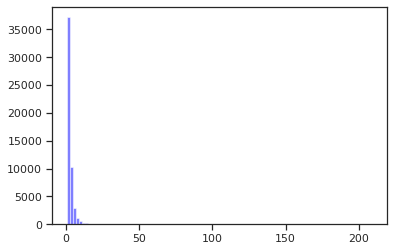

In [39]:
# predicted value distribution
import matplotlib.pyplot as plt

num_bins = 100
n, bins, patches = plt.hist(lgb_preds_fi, num_bins, facecolor='blue', alpha=0.5)
plt.show()

In [40]:
# feature importance
final_importance_fi = feature_importance_df_fi[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)
final_importance_fi.reset_index(inplace=True)
final_importance_fi

,feature,importance
0,day_of_year,3965.2
1,enc_S100_I100_C100_C101_std_clipped,2145.2
2,rolling_std_I100_7_C101,2057.8
3,rolling_mean_tmp_I100_1_7_I100_C100_C101,1969.2
4,enc_S100_I100_C100_C101_mean_clipped,1701.8
5,rolling_mean_tmp_14_14_clipped,1664.2
6,I100,1632.4
7,day,1411.6
8,QTT_lag_3,1004.4
9,enc_S100_C100_std_clipped,995.2


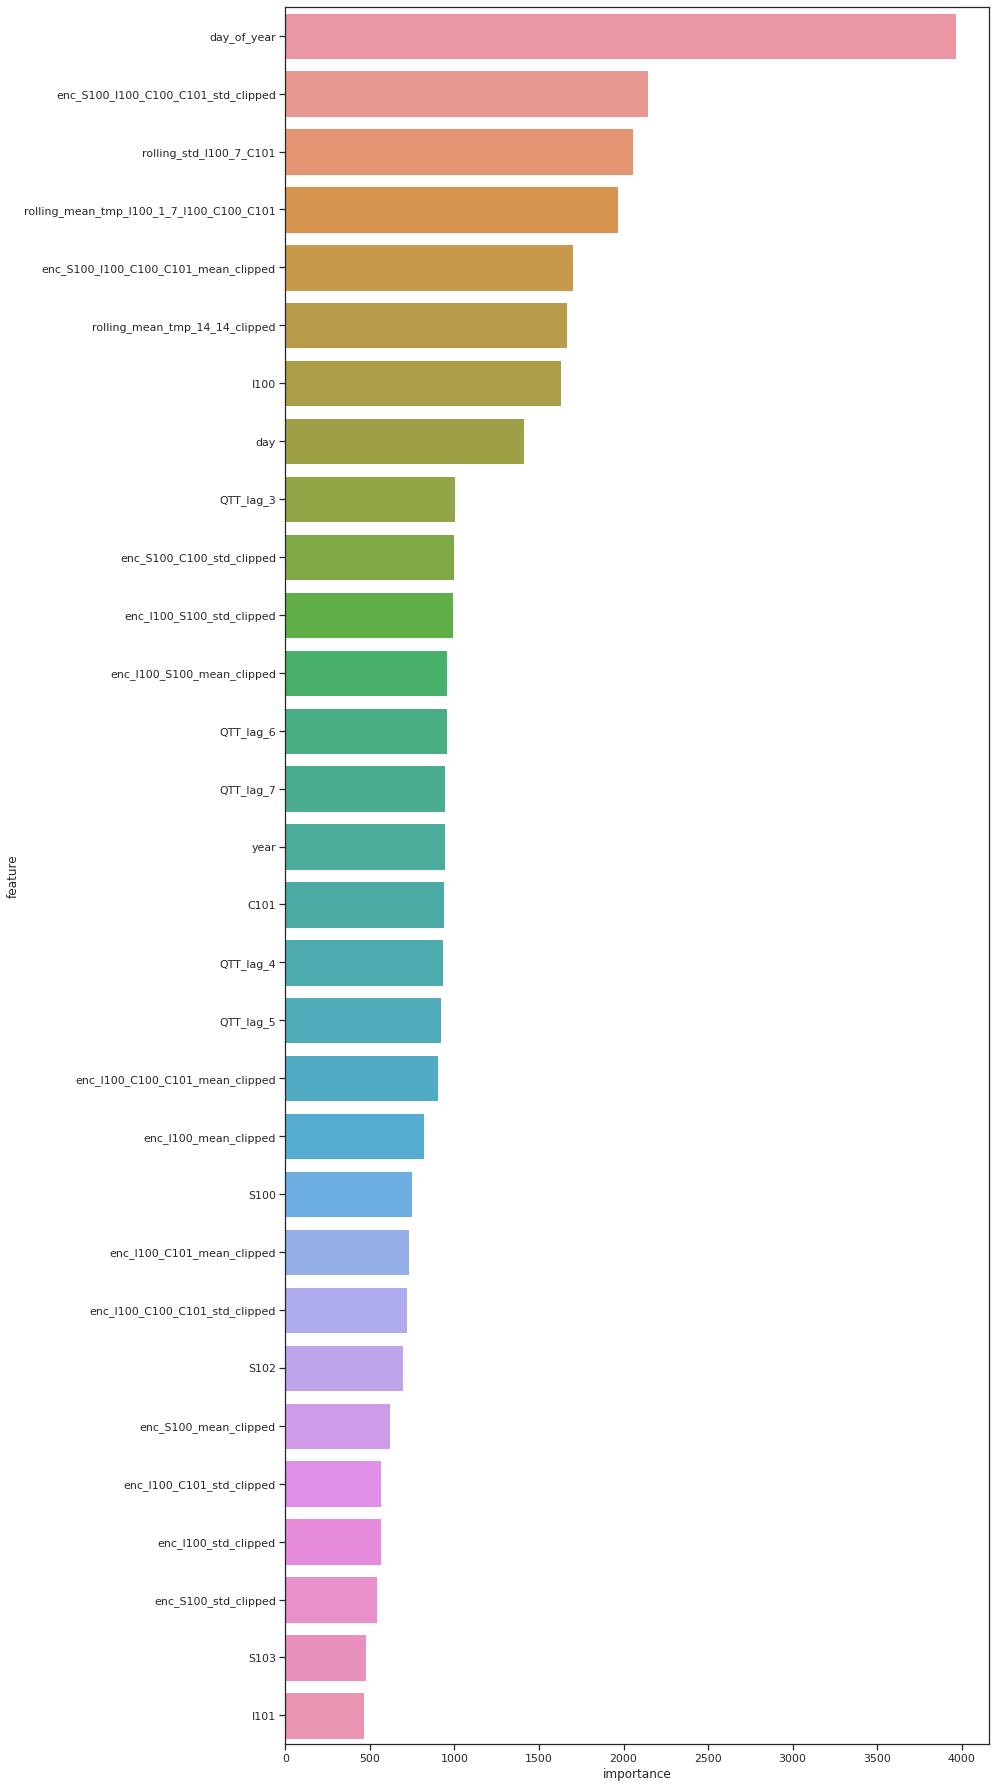

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,25))
sns.barplot(x="importance",y="feature",data=final_importance_fi)
plt.tight_layout()
plt.savefig(os.path.join(PATH_RESULTS,'lgbm_importances.png'))

In [42]:
df_submission_sample.reset_index(drop=True,inplace=True)
df_submission_sample['QTT'] = predictions_submission_fi.mean(axis=1)
df_submission_sample.head()

,ID,QTT,DATE,S100,I100,C100,C101,item_id,date_block_num,I101,...,enc_S100_C100_std_clipped,enc_I100_C101_mean_clipped,enc_I100_C101_std_clipped,enc_I100_S100_mean_clipped,enc_I100_S100_std_clipped,enc_I100_C100_C101_mean_clipped,enc_I100_C100_C101_std_clipped,enc_S100_I100_C100_C101_mean_clipped,enc_S100_I100_C100_C101_std_clipped,QTT_reference
0,2021-12-19_0_1_12_76,2.435785,2021-12-19,0,1,12,76,1_12_76,258,2,...,0.592773,0.677734,1.580078,0.340576,0.774414,0.584961,1.304688,0.513672,1.075195,2.544001
1,2021-12-19_0_1_12_140,1.772491,2021-12-19,0,1,12,140,1_12_140,258,2,...,0.592773,0.438721,1.067383,0.340576,0.774414,0.355469,0.911133,0.273193,0.705078,1.771426
2,2021-12-19_0_1_12_164,1.763320,2021-12-19,0,1,12,164,1_12_164,258,2,...,0.592773,0.380371,1.001953,0.340576,0.774414,0.366455,0.950684,0.323242,0.710938,1.875576
3,2021-12-19_0_1_12_201,1.586429,2021-12-19,0,1,12,201,1_12_201,258,2,...,0.592773,0.373779,0.889648,0.340576,0.774414,0.294678,0.772949,0.273193,0.633789,1.648686
4,2021-12-19_0_1_12_339,1.580635,2021-12-19,0,1,12,339,1_12_339,258,2,...,0.592773,0.346924,0.872559,0.340576,0.774414,0.254150,0.691895,0.264648,0.644043,1.645443


saving..
training_sub_c_model_v3_cv_2.0989_local.csv


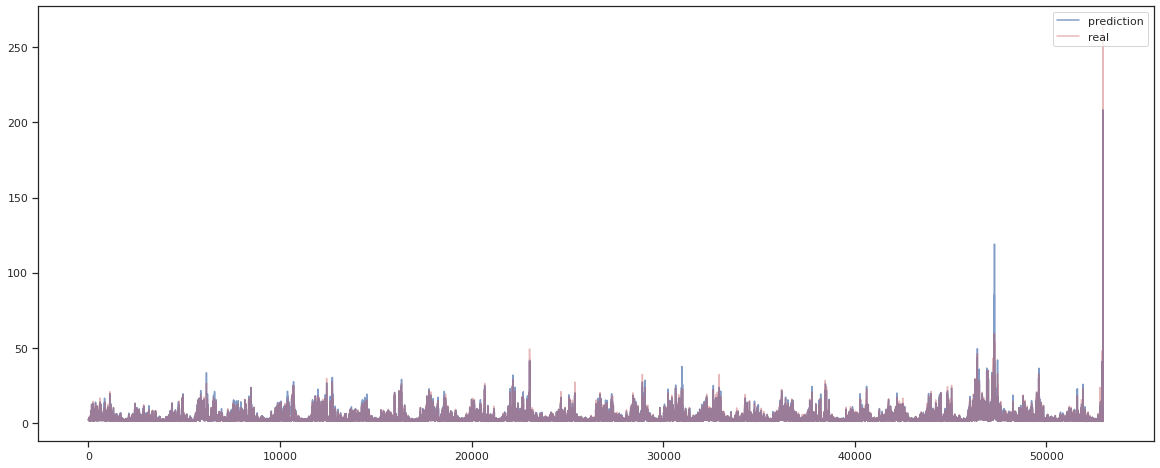

Final score mean_squared_error
Score train: 0.7418783219834437


In [43]:
save = True
if save:
    filename_submission= 'training_sub_'+model_version+'_cv_'+str(np.round(cv_score,4))+'_local.csv'
    print('saving..')
    print(filename_submission)
    df_submission_sample[['ID','QTT']].to_csv(os.path.join(PATH_RESULTS,'submissions',filename_submission),index=None)
    
###################
result = pd.read_csv(os.path.join(PATH_RESULTS,'submissions',submission_top_reference))

df_submission_sample['QTT_reference']= result['QTT'].copy()
df_submission_sample[['QTT_reference','QTT']][-20:]

fig = plt.figure(figsize=(20,8))
plt.plot(df_submission_sample['QTT'],'b', alpha=0.7)
plt.plot(result['QTT'],'r', alpha=0.4)
plt.legend(["prediction", "real"], loc ="upper right")
plt.show()

#######
difference = mean_squared_error(df_submission_sample['QTT'],result['QTT'], squared=False)

print('Final score mean_squared_error')
print('Score train:',difference)


In [44]:
year = 2019
window = 2

def get_features(year,window):
    df_before = df_sales[['DATE','I101','I102','I103','S101','S102','S103','S100','I100','C100','C101']][(df_sales['DATE'] > str(year-window)+'-01-01') & (df_sales['DATE'] < str(year)+'-01-01')]

    f_agg = {}

    for value in ['I101','I102','I103','S101','S102','S103']:
        f_agg[value] = ['mean', 'min', 'max']

    original_columns = ['S100','I100','C100','C101']
    result = df_before.groupby(original_columns).agg(f_agg)
    result = result.reset_index()

    #result.columns = result.columns.droplevel(0)
    result.columns = ["_".join(x) if x[0] not in original_columns else x[0] for x in result.columns.ravel() ]

    result['year'] = year
    return result


In [45]:
df_features_2019 = get_features(2019,2)
df_features_2020 = get_features(2020,2)
df_features_2021 = get_features(2021,2)

In [46]:
df_submission_sample_save = df_submission_sample.copy()

In [47]:
df_submission_sample = df_submission_sample_save.copy()

df_2019 = df_sales[(df_sales['DATE'] >= '2019-01-01') & (df_sales['DATE'] < '2020-01-01')].copy()
df_2020 = df_sales[(df_sales['DATE'] >= '2020-01-01') & (df_sales['DATE'] < '2020-01-01')].copy()
df_2021 = df_sales[(df_sales['DATE'] >= '2021-01-01') & (df_sales['DATE'] < '2022-01-01')].copy()

df_2019 = df_2019.merge(df_features_2019,on=['S100','I100','C100','C101','year'], how='left')
df_2020 = df_2020.merge(df_features_2020,on=['S100','I100','C100','C101','year'], how='left')
df_2021  =df_2021.merge(df_features_2021,on=['S100','I100','C100','C101','year'], how='left')

df_submission_sample  = df_submission_sample.merge(df_features_2021,on=['S100','I100','C100','C101','year'], how='left')


df_sales2 = pd.concat([df_2019,df_2020,df_2021])
df_sales2.head()

df_sales2.replace([np.inf, -np.inf, np.nan],0,inplace=True)
df_submission_sample.replace([np.inf, -np.inf, np.nan],0,inplace=True)
#features_names = set(list(df_sales2.columns))- set(['DATE','QTT'])
features_names = set(df_sales2.columns)-set(['QTT','DATE','item_id','ID', 'date_block_num','QTT_clipped']) 
X_train = df_sales2[features_names].copy()
y_train = df_sales2['QTT']

X_submission = df_submission_sample[features_names].copy()

In [48]:
feature_engineering  = ['I103', 'day_of_year', 'year', 'I103_mean', 'is_quarter_start', 'I103_max', 'is_year_start', 'C100', 'S103', 'S101_max', 'C101', 'S103_mean', 'is_month_end', 'I101', 'day_of_week', 'S103_max', 'month', 'day', 'is_month_start', 'S100', 'I100', 'S102_max', 'I102', 'I102_min', 'I101_mean', 'S103_min', 'S101_min', 'I102_mean', 'S101', 'S101_mean', 'I102_max', 'S102', 'S102_min', 'I101_min', 'S102_mean', 'I101_max', 'I103_min']

In [49]:
#features_names = set(df_sales2.columns)-set(['QTT','DATE','item_id','ID', 'date_block_num']) 
main_features = ['S100', 'I100', 'C100', 'C101', 'month', 'year', 'day','I101', 'I102', 'I103', 'S101', 'S102', 'S103']
features_names = list(set(important_features[-10:]) | set(main_features) |  set(feature_engineering))
#features_names = list( set(feature_engineering))

X_train = df_sales2[features_names].copy()
y_train = df_sales2['QTT']

X_submission = df_submission_sample[features_names].copy()
print(features_names)

['day_of_week', 'S101_mean', 'enc_I100_std_clipped', 'QTT_lag_7', 'S103_min', 'I103_min', 'enc_I100_C101_mean_clipped', 'S101', 'is_year_start', 'month', 'C100', 'I103_max', 'S101_min', 'I101_mean', 'S103_mean', 'I103', 'C101', 'day', 'I102', 'S102_min', 'is_month_end', 'I101', 'QTT_lag_5', 'year', 'day_of_year', 'S102', 'I101_max', 'S102_max', 'is_month_start', 'S102_mean', 'I102_max', 'I102_mean', 'rolling_mean_tmp_14_14_clipped', 'I102_min', 'enc_I100_C101_std_clipped', 'enc_S100_std_clipped', 'S100', 'is_quarter_start', 'S103_max', 'enc_S100_mean_clipped', 'S103', 'S101_max', 'I100', 'I103_mean', 'I101_min']


In [50]:
params = {      
   'device' : 'cpu',
    'boosting_type': 'gbdt',
   'objective': 'tweedie',
   'tweedie_variance_power': 1.1,
    'metric': 'rmse',
    'subsample': 0.6,
    'subsample_freq': 1,
    'learning_rate': 0.1,

    #'num_leaves': 200, #110 #100 #150 large, but over-fitting
    #'max_depth': 10, # deal with over-fitting
    #'min_data_in_leaf': 30, # deal with over-fitting
    
    'num_leaves': 2**11-1,
    'min_data_in_leaf': 2**12-1,
    
    'feature_fraction': 0.6,
    'max_bin': 100,
    #'n_estimators': …,   
    'boost_from_average': False,
    'verbose': -1,
    'num_threads': 8
   }    

In [51]:
model_version = 'c_model_v4_lessdata'

nfolds = 5

nrepeats = 2 

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=nfolds, random_state=11, shuffle=True)
skf.get_n_splits(X_train, y_train)
print(skf)
    
folds = RepeatedKFold(n_splits=nfolds, n_repeats=nrepeats, random_state=11)
print(folds)

fold_pred_fi = np.zeros(len(X_train))


feature_importance_df_fi = pd.DataFrame()
predictions_submission_fi = pd.DataFrame()

lgb_preds_fi = np.zeros(len(X_submission))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(y_train.values,y_train.values)):
#for fold_, (trn_idx, val_idx) in enumerate(skf.split(y_train.values,y_train.values)):
    
    print(20*'*'," fold n°{}".format(fold_))
    
    trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx]) #categorical_feature=categorical_feats
    val_data = lgb.Dataset(X_train.iloc[val_idx], label=y_train.iloc[val_idx]) #categorical_feature=categorical_feats

    print('Training ...')
    iteration = 3000
    lgb_model = lgb.train(params, trn_data, iteration, valid_sets = [trn_data, val_data], verbose_eval=50, early_stopping_rounds = 100)
    
    print('make predictions...')
    X_train_pred      = lgb_model.predict(X_train.iloc[trn_idx], num_iteration=lgb_model.best_iteration)
    X_validation_pred = lgb_model.predict(X_train.iloc[val_idx], num_iteration=lgb_model.best_iteration)
    #X_test_pred       = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

    X_train_pred = np.maximum(X_train_pred, 0)
    X_validation_pred = np.maximum(X_validation_pred, 0)
    #X_test_pred = np.maximum(X_test_pred, 0)

    

    df_train_rmse = mean_squared_error(y_train.iloc[trn_idx],X_train_pred, squared=False)
    df_val_rmse   = mean_squared_error(y_train.iloc[val_idx],X_validation_pred, squared=False)
    #df_test_rmse  = mean_squared_error(y_test,X_test_pred, squared=False)

    print('Final score mean_squared_error')
    print('Score train:',df_train_rmse)
    print('Score val  :',df_val_rmse)
    #print('Score test :',df_test_rmse)


    fold_pred_fi[val_idx] = X_validation_pred
    
    fold_importance_df_fi = pd.DataFrame()
    fold_importance_df_fi["feature"] = X_train.columns
    fold_importance_df_fi["importance"] = lgb_model.feature_importance()
    fold_importance_df_fi["fold"] = fold_ + 1
    feature_importance_df_fi = pd.concat([feature_importance_df_fi, fold_importance_df_fi], axis=0)
    
    
    
    print('Predict submission ')
    X_submission_pred = lgb_model.predict(X_submission.values, num_iteration=lgb_model.best_iteration)
    X_submission_pred = np.maximum(X_submission_pred, 0)

    lgb_preds_fi += X_submission_pred / (nfolds*nrepeats)
    #lgb_preds_fi += X_submission_pred / (nfolds)
    
    predictions_submission_fi[str(fold_ + 1)] = X_submission_pred
    
    
    model_name = os.path.join(PATH_RESULTS,'lightgbm',model_version,'model_fold_'+str(fold_ + 1)+'.txt')
    print('saving model..',model_name)
    lgb_model.save_model(model_name, num_iteration=lgb_model.best_iteration)
    
    #############################

print("CV score: {:<8.5f}".format(np.sqrt(mean_squared_error(fold_pred_fi, y_train))))

StratifiedKFold(n_splits=5, random_state=11, shuffle=True)
RepeatedKFold(n_repeats=2, n_splits=5, random_state=11)
********************  fold n°0
Training ...
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 2.36809	valid_1's rmse: 2.44342
[100]	training's rmse: 2.31005	valid_1's rmse: 2.38361
[150]	training's rmse: 2.27256	valid_1's rmse: 2.34671
[200]	training's rmse: 2.24441	valid_1's rmse: 2.31816
[250]	training's rmse: 2.22173	valid_1's rmse: 2.29461
[300]	training's rmse: 2.20403	valid_1's rmse: 2.27782
[350]	training's rmse: 2.18778	valid_1's rmse: 2.26235
[400]	training's rmse: 2.17429	valid_1's rmse: 2.24916
[450]	training's rmse: 2.1614	valid_1's rmse: 2.23757
[500]	training's rmse: 2.14986	valid_1's rmse: 2.22788
[550]	training's rmse: 2.13812	valid_1's rmse: 2.218
[600]	training's rmse: 2.12747	valid_1's rmse: 2.20879
[650]	training's rmse: 2.11792	valid_1's rmse: 2.20208
[700]	training's rmse: 2.10822	valid_1's rmse: 2.19446
[750]	trainin

In [52]:
cv_score = np.sqrt(mean_squared_error(fold_pred_fi, y_train))
print("CV score: {:<8.5f}".format(np.sqrt(mean_squared_error(fold_pred_fi, y_train))))

CV score: 2.10587 


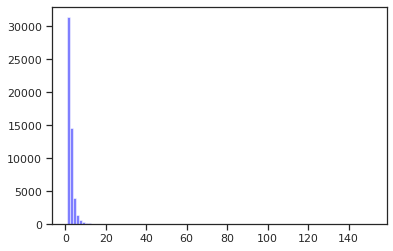

saving..
training_sub_c_model_v4_lessdata_cv_2.1059_local.csv


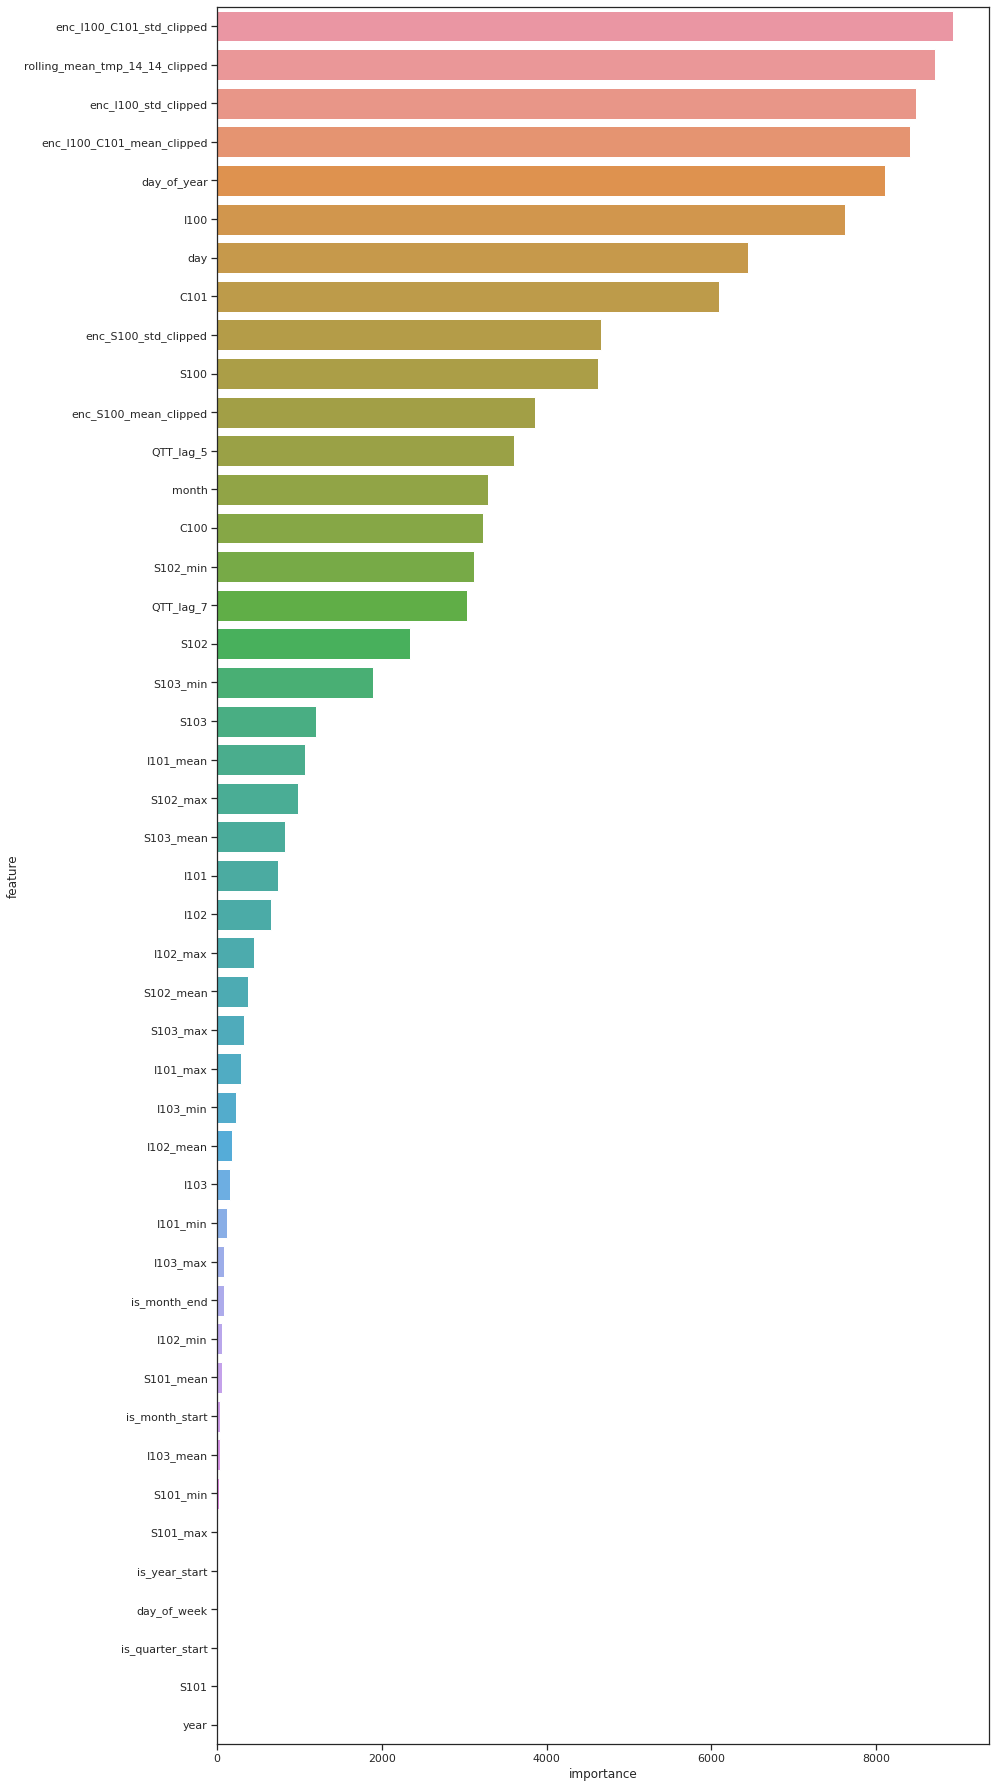

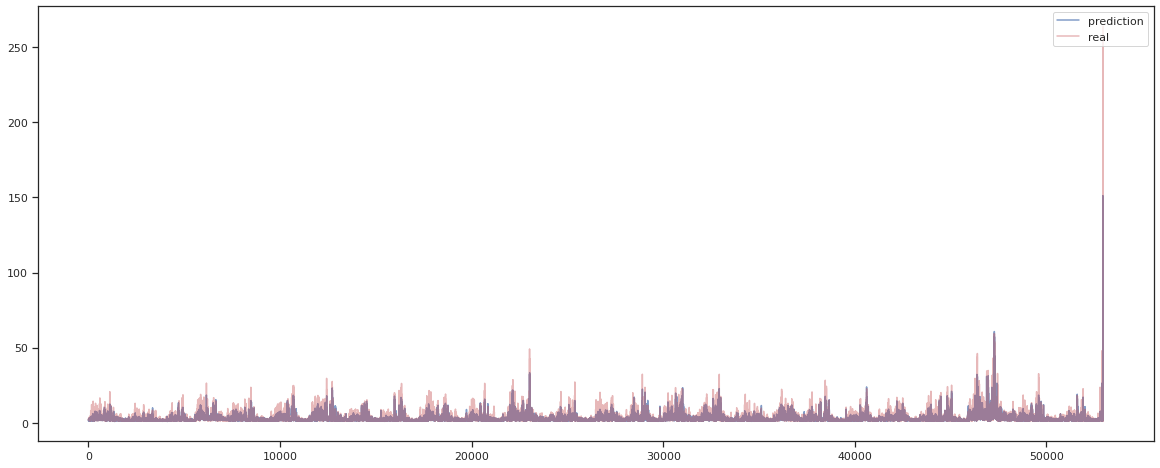

Final score mean_squared_error
Score train: 1.4257522411777621


In [53]:
# predicted value distribution
import matplotlib.pyplot as plt

num_bins = 100
n, bins, patches = plt.hist(lgb_preds_fi, num_bins, facecolor='blue', alpha=0.5)
plt.show()

# feature importance
final_importance_fi = feature_importance_df_fi[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)
final_importance_fi.reset_index(inplace=True)
final_importance_fi

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,25))
sns.barplot(x="importance",y="feature",data=final_importance_fi)
plt.tight_layout()
plt.savefig(os.path.join(PATH_RESULTS,'lgbm_importances.png'))

df_submission_sample.reset_index(drop=True,inplace=True)
df_submission_sample['QTT'] = predictions_submission_fi.mean(axis=1)
df_submission_sample.head()

save = True
if save:
    filename_submission= 'training_sub_'+model_version+'_cv_'+str(np.round(cv_score,4))+'_local.csv'
    print('saving..')
    print(filename_submission)
    df_submission_sample[['ID','QTT']].to_csv(os.path.join(PATH_RESULTS,'submissions',filename_submission),index=None)
    
###################
result = pd.read_csv(os.path.join(PATH_RESULTS,'submissions',submission_top_reference))

df_submission_sample['QTT_reference']= result['QTT'].copy()
df_submission_sample[['QTT_reference','QTT']][-20:]

fig = plt.figure(figsize=(20,8))
plt.plot(df_submission_sample['QTT'],'b', alpha=0.7)
plt.plot(result['QTT'],'r', alpha=0.4)
plt.legend(["prediction", "real"], loc ="upper right")
plt.show()

#######
difference = mean_squared_error(df_submission_sample['QTT'],result['QTT'], squared=False)

print('Final score mean_squared_error')
print('Score train:',difference)
